# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="./images/pic1.png"/>

Then you will want to run the above command:

<img src="./images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Imports

In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import datetime
import pickle


from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
# look the data

<img src="./images/aventura.jpg"/>


# 1. Data Exploration

# 1.1 Portfolio

In [5]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
portfolio.shape

(10, 6)

In [7]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [9]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [10]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [11]:
# oh no, list in dataset T_T

In [12]:
# lets convert this list to dummy

In [13]:
def clean_portfolio(portfolio):
    '''
    clean portfolio dataframe
    
    INPUT:
    portfolio - df
    
    OUTPUT:
    portfolio - df
    
    '''
    # day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [14]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio = cleaned_portfolio.rename(columns={'reward':'portfolio_reward'})
cleaned_portfolio.head()

,portfolio_reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### Is possible see all information about the product/promotion

In [15]:
cleaned_portfolio.describe()

,portfolio_reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.200000,7.700000,156.000000,0.800000,1.0,0.900000,0.600000,0.400000,0.400000,0.200000
std,3.583915,5.831905,55.713553,0.421637,0.0,0.316228,0.516398,0.516398,0.516398,0.421637
min,0.000000,0.000000,72.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,120.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,8.500000,168.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,10.000000,168.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
max,10.000000,20.000000,240.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


# 1.2 Profile

In [16]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [17]:
# lets clean this profile df

In [18]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - df
    
    OUTPUT:
    profile - df cleaned
    
    '''
    # clean nan values
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    # removed because is no clear the information with nan
    profile.dropna(inplace=True)
    
    # number days user is member
    profile['memberdays'] = datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    profile['age'] = profile['age'].astype(int)
    
    #add Age_group column
    profile.loc[(profile.age < 20) , 'Age_group'] = 'Under 20'
    profile.loc[(profile.age >= 20) & (profile.age <= 29) , 'Age_group'] = '20-29'
    profile.loc[(profile.age >= 31) & (profile.age <= 30) , 'Age_group'] = '30-39'
    profile.loc[(profile.age >= 40) & (profile.age <= 49) , 'Age_group'] = '40-49'
    profile.loc[(profile.age >= 50) & (profile.age <= 59) , 'Age_group'] = '50-59'
    profile.loc[(profile.age >= 60) , 'Age_group'] = '60'
    
    
    return profile

In [19]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays,Age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1360,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1427,60
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1075,60
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1151,60
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1241,50-59


## 1.2.1 Profile Visualization

### Histogram of Customer Age

In [20]:
cleaned_profile.gender.value_counts()/cleaned_profile.shape[0] * 100

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [21]:
cleaned_profile.Age_group.value_counts()/cleaned_profile.shape[0] * 100

60          39.629005
50-59       23.885329
40-49       15.575042
20-29        9.234401
Under 20     1.382799
Name: Age_group, dtype: float64

Text(0.5, 0, 'Customer Age')

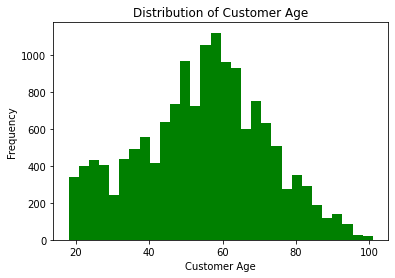

In [22]:
user_age = cleaned_profile['age'].plot(kind='hist', bins=30,color='green' ,title='Distribution of Customer Age')
user_age.set_xlabel("Customer Age")

### Histogram of the days being member

Text(0.5, 0, 'Days')

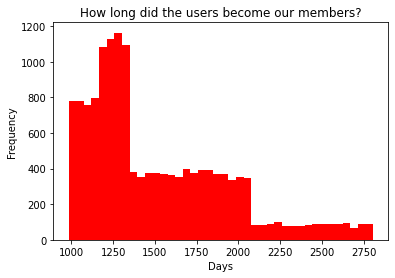

In [23]:
memberdays = cleaned_profile['memberdays'].plot(kind='hist', bins=40, color='red',title='How long did the users become our members?')
memberdays.set_xlabel("Days")

### Histogram of User Income

Text(0.5, 0, 'Income')

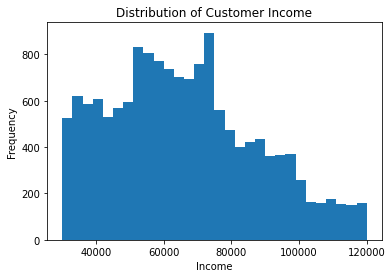

In [24]:
plt.figure()
user_income = cleaned_profile['income'].plot(kind='hist', bins=30, title='Distribution of Customer Income')
user_income.set_xlabel("Income")

# 1.3 Transcript

In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [26]:
# explore transcript
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [27]:
transcript.event.value_counts().head()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [28]:
transcript[transcript.person=='78afa995795e4d85b5d9ceeca43f5fef'].head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132


In [29]:
tmp = pd.concat([transcript.drop(['value'],axis=1), transcript['value'].apply(pd.Series)],axis=1)

In [30]:
transcript = tmp.copy()

In [31]:
transcript.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [32]:
transcript.shape

(306534, 7)

In [33]:
transcript.isna().sum()

person           0
event            0
time             0
offer id    172532
amount      167581
offer_id    272955
reward      272955
dtype: int64

In [34]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# 1.4 Merging Data

### Create table Offers

In [35]:
# only offer
offer = transcript[transcript.event.isin(['offer received', 'offer viewed','offer completed'])]

In [36]:
offer.shape

(167581, 7)

In [37]:
offer['offer id'].nunique()

10

In [38]:
offer.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [39]:
offer.event.unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

## 1.4.1 Join Data

In [40]:
## Join portfolio and offers

In [41]:
cleaned_portfolio.head(1)

,portfolio_reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0


In [42]:
offer.head(1)

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN


In [43]:
offer = offer.merge(cleaned_portfolio, left_on='offer id', right_on='id', how='left')
offer = offer.drop(['offer id'],axis=1)

In [44]:
offer.shape

(167581, 17)

In [45]:
offer.head(3)

,person,event,time,amount,offer_id,reward,portfolio_reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,NaN,5.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,NaN,5.0,20.0,240.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,NaN,2.0,10.0,168.0,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [46]:
# Removind information events

In [47]:
offer = offer[offer.informational!=1.0]

In [48]:
offer.event.value_counts()

offer received     61042
offer viewed       46894
offer completed    33579
Name: event, dtype: int64

## 1.4.2 Add information about users

In [49]:
profile.head(2)

,gender,age,id,became_member_on,income,memberdays,Age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1360,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1427,60


In [50]:
tmp = offer.merge(profile, left_on='person', right_on='id', how='left')
#tmp = tmp.dropna(subset=['id_x', 'id_y'])
tmp = tmp.drop(['id_y'],axis=1)
tmp = tmp.rename(columns={'id_x':'id'})
offer_complet = tmp

In [51]:
offer_complet.shape

(141515, 23)

In [52]:
offer_complet.head(3)

,person,event,time,amount,offer_id,reward,portfolio_reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational,gender,age,became_member_on,income,memberdays,Age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,NaN,5.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,NaN,5.0,20.0,240.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,NaN,2.0,10.0,168.0,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,1.0,0.0,0.0,1.0,0.0,M,68.0,20180426.0,70000.0,1075.0,60


In [53]:
offer_complet.event.value_counts()

offer received     61042
offer viewed       46894
offer completed    33579
Name: event, dtype: int64

In [54]:
offer_complet[offer_complet.person=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,amount,offer_id,reward,portfolio_reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational,gender,age,became_member_on,income,memberdays,Age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,NaN,5.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60
12052,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,NaN,5.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60
22167,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,20170509.0,100000.0,1427.0,60
67742,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,NaN,NaN,NaN,10.0,10.0,168.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60
77951,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,NaN,NaN,NaN,10.0,10.0,168.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60
92310,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,NaN,NaN,5.0,5.0,120.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60
104968,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,20170509.0,100000.0,1427.0,60
104969,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75.0,20170509.0,100000.0,1427.0,60
127893,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,582,NaN,NaN,NaN,5.0,5.0,120.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60


# Summary: At this point

An offer_complet table was created with the offers and the customers who received it. from here we will analyze the Q we can receive.


<img src="./images/science.png"/>

# 2. Data Visualization

# 2.1 Heuristc Analysis

## 2.1.1 How many offerts is send by users

In [55]:
offer_complet.event.unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [56]:
offer_complet.head(1)

,person,event,time,amount,offer_id,reward,portfolio_reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational,gender,age,became_member_on,income,memberdays,Age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,NaN,5.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,1.0,0.0,1.0,0.0,0.0,F,75.0,20170509.0,100000.0,1427.0,60


<AxesSubplot:title={'center':' Distribution of offer types'}>

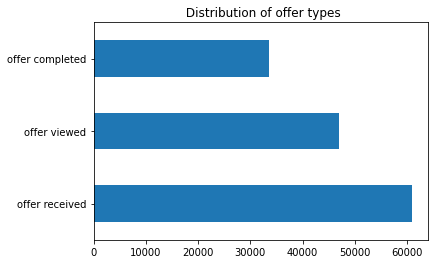

In [57]:
offer_complet['event'].value_counts().plot.barh(title=' Distribution of offer types')

# 2.1.2 How many people have for age

<AxesSubplot:title={'center':' Distribution of age groups'}>

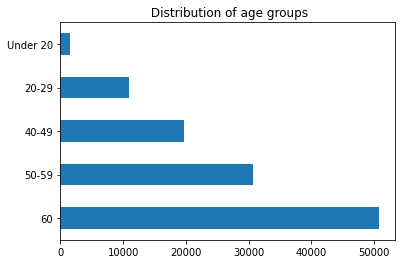

In [58]:
offer_complet['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')

# 2.1.3 Gender M and F for Age Groups 

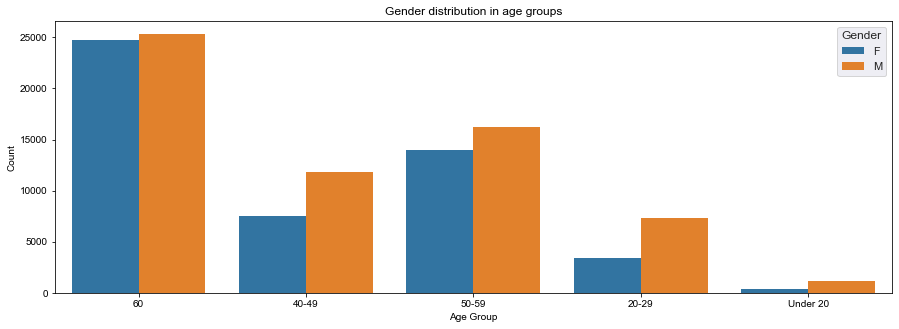

In [59]:
plot_gender = offer_complet[offer_complet['gender'] != 'O']

plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

# 2.1.4 Gender Statistic

<AxesSubplot:ylabel='gender'>

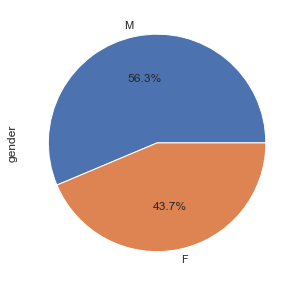

In [60]:
plot_gender.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

# 2.1.5 Gender And offers

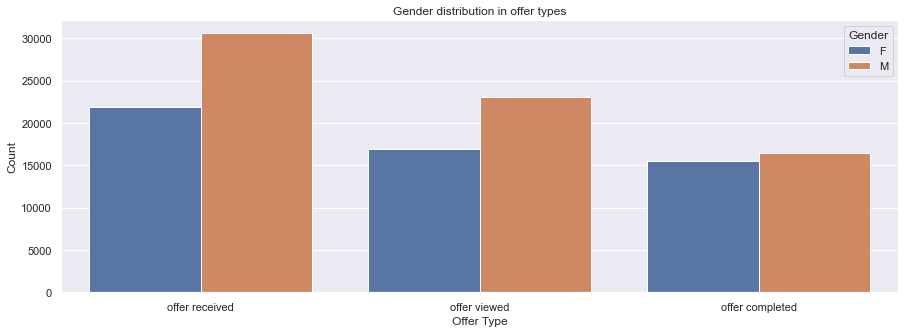

In [61]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

# 2.1.6 Age and offers

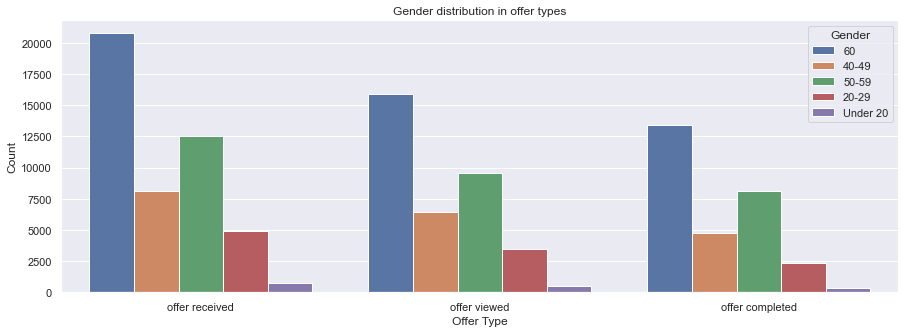

In [62]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "Age_group", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

## 2.1.6 Statistic for gender and bogo

In [63]:
offer_complet[offer_complet.bogo==1].gender.value_counts()/offer_complet.shape[0] * 100

M    19.636788
F    14.216161
O     0.472741
Name: gender, dtype: float64

## 2.1.7 Statistic for gender and discount

In [64]:
offer_complet[offer_complet.discount==1].gender.value_counts()/offer_complet.shape[0] * 100

M    18.220683
F    13.197188
O     0.469208
Name: gender, dtype: float64

<AxesSubplot:ylabel='Age_group'>

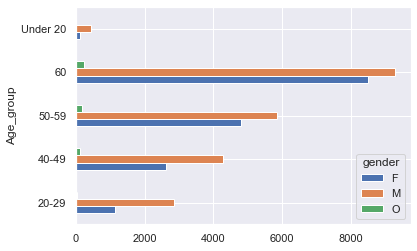

In [65]:
offer_complet[offer_complet.discount==1].groupby('Age_group').gender.value_counts().unstack().plot.barh()

<AxesSubplot:ylabel='Age_group'>

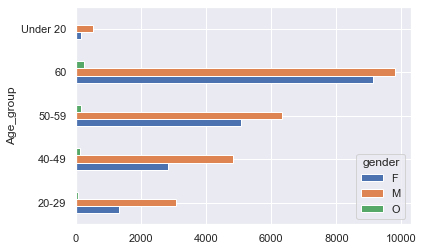

In [66]:
offer_complet[offer_complet.discount==0].groupby('Age_group').gender.value_counts().unstack().plot.barh()

# 2.1.8 Age and discount

<AxesSubplot:ylabel='Age_group'>

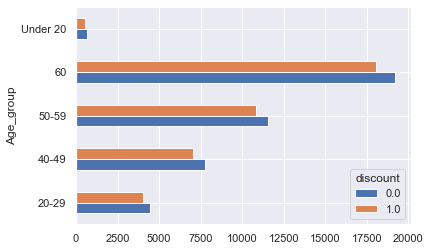

In [67]:
offer_complet.groupby('Age_group').discount.value_counts().unstack().plot.barh()

# 2.1.9 Age and Bogo

<AxesSubplot:ylabel='Age_group'>

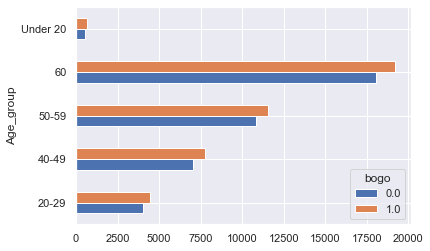

In [68]:
offer_complet.groupby('Age_group').bogo.value_counts().unstack().plot.barh()

# 2.1.10 Discount - Age - Gender

<AxesSubplot:ylabel='Age_group,gender'>

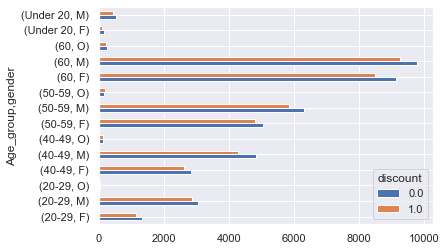

In [69]:
offer_complet.groupby(['Age_group','gender']).discount.value_counts().unstack().plot.barh()

# 2.1.11 Bogo - Age - Gender

<AxesSubplot:ylabel='Age_group,gender'>

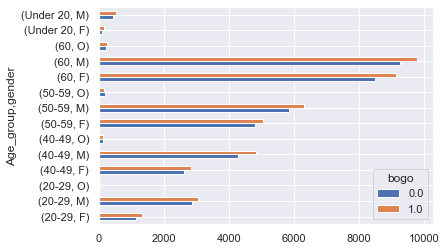

In [70]:
offer_complet.groupby(['Age_group','gender']).bogo.value_counts().unstack().plot.barh()

# 3. Results and Discussion

## Q1. Which demographic groups respond best to which offer type?

In the figure 2.1.5 is possible to see groups by gender, and not is possible to see any between in groups. 

# Q2. Have any difference for response offer based in Age?

The figure 2.1.6, the Age groups, the offer not is different.

# Q3. Have differences in bogo or discount for groups?

In figure 2.1.9 and 2.1.8 not have difference in gender groups.

And in figure 2.1.10 and 2.1.11 not have difference in age/group gender.

# 4. Justification


The segmentations showed that the groups by gender or age, have the same degree of dispersion. How it was used by coupons, demand a greater understanding. What makes a person buy, and what makes a person buy when they receive the discount is an always-in-depth discussion that generalization always gets complicated.
But, the data presents excellent possibilities for a study, of how to understand the buying behavior of each group or if the groups are the same in behavior. In this essay, it was not possible to visualize a behavior that differs an elderly man from a young woman in the 20-year-old group.

# 5. Reflection

I always have doubts about when to use a machine learning model or if the problem is a software engineering problem, I like to think and understand the problem very well, before going out applying some regression on the data.
In this challenging problem, I was analyzing several paths until I found one that I could apply some modeling, but, I didn’t see a very interesting path. At one point in the course, this subject was addressed about when to apply a machine learning model or not.
In this case, it is possible to apply, but will the gain be substantial, in my view, it may be, but it is still vague. The data is very good, it has wealth, but I would need to understand more and more about the customers and the data, so that I can apply a modeling start.
Data science is an art, which requires patience and reflection, in addition to having complete control of the information, not just applying the model to be applied.
In short, I was blessed with the challenge, just thinking about how to improve the problem, so it finally becomes a machine learning problem.

# 6. Future Improviments

All tue groups received offer, and all use, the distribuition is so interessante. Not have any great difference. For the future, is interesting use, other offers.

For ML models, is possible test the received and used the offers.